In [1]:
CUDA_VISIBLE_DEVICES=6

In [2]:
import warnings
# Ingnore warnings
warnings.filterwarnings("ignore")

import numpy as np
import scipy as sp
import sklearn
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
import pandas.util.testing as tm
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from keras.models import load_model
import os
import random

2021-08-09 10:16:43.734666: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
# Load datasets
data_folder = '../../../../data/zahs/Projects/DACCOMPLI/'

df_test_X = pd.read_csv(os.path.join(data_folder, "Test1.csv"))
df_test_Y = pd.read_csv(os.path.join(data_folder,"Test2.csv"))
# train_X = pd.read_csv(os.path.join(data_folder,"Train1.csv"))
# train_Y = pd.read_csv(os.path.join(data_folder, "Train2.csv"))
model_file = os.path.join(data_folder,'best_cnn_model_test_val.hdf5')
model = load_model(model_file)

2021-08-09 10:17:45.107031: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-09 10:17:45.109094: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-09 10:17:45.333284: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:06:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-08-09 10:17:45.335799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:07:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-08-09 10:17:45.338294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:0a:00.0 name: Tesla K80 computeCapab

In [4]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 27205, 10)         30        
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 27197, 64)         5824      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5439, 64)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5431, 128)         73856     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1086, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 139008)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 139008)           

In [5]:
test_Y = df_test_Y[df_test_Y.columns[1:]]

In [6]:
test_X = df_test_X[df_test_X.columns[1:]]

In [7]:
x_test = test_X.to_numpy()

In [8]:
y_test = test_Y.to_numpy()

In [9]:
from SALib.sample import saltelli,finite_diff, fast_sampler
from SALib.analyze import morris,sobol, dgsm, fast, delta
from SALib.util import read_param_file
from SALib.sample.morris import sample
from SALib.plotting.morris import horizontal_bar_plot, covariance_plot, sample_histograms


In [10]:
feature_labels = [f'f {i}' for i in range(27205)]

In [11]:
problem = {
  'num_vars': 27205,
  'names': feature_labels,
  'bounds': [[0.0, 2.0]]*27205 #standard scaled
}

In [12]:
## 1- Morris
from SALib.analyze import morris
X = sample(problem, N=10, num_levels=2, optimal_trajectories=None)

In [13]:
Y = model.predict(X)
Y = np.nan_to_num(Y).flatten()


2021-08-09 11:21:12.763217: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-09 11:21:12.776211: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300145000 Hz
2021-08-09 11:21:13.132712: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-08-09 11:21:14.060451: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


In [14]:
Y = np.float64(Y)
Y = np.nan_to_num(Y).flatten()
from SALib.sample.morris import sample


si_morris = morris.analyze(problem, X, Y, conf_level=0.95, 
                    print_to_console=False,
                    num_levels=2, num_resamples=100)

In [15]:
si_morris.keys()

dict_keys(['names', 'mu', 'mu_star', 'sigma', 'mu_star_conf'])

x bounds [0.         0.12332005]


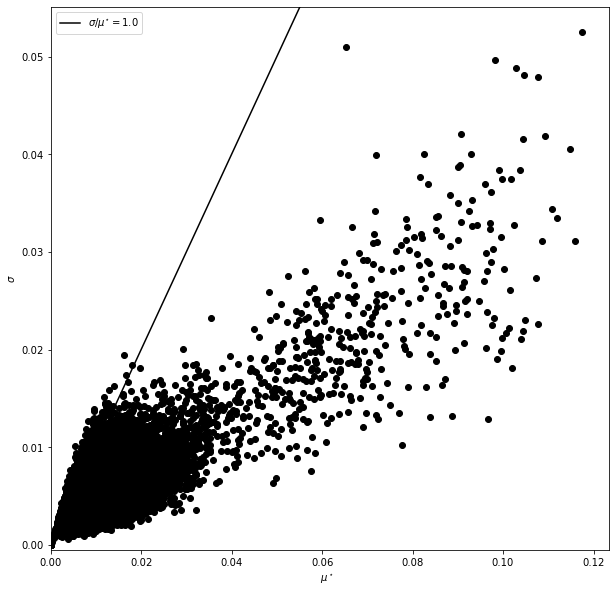

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))


param_dict = {}
if si_morris['sigma'] is not None:
    # sigma is not present if using morris groups
    y = si_morris['sigma']
    out = ax.scatter(si_morris['mu_star'], y, c=u'k', marker=u'o',
                      **param_dict)
    ax.set_ylabel(r'$\sigma$')

    ax.set_xlim(0,)
    ax.set_ylim(0,)

    x_axis_bounds = np.array(ax.get_xlim())
    print('x bounds',x_axis_bounds)
    line1, = ax.plot(x_axis_bounds, x_axis_bounds, 'k-', label = r'$\sigma / \mu^{\star} = 1.0$')
    # line2, = ax.plot(x_axis_bounds, 0.5 * x_axis_bounds, 'k--')
    # line3, = ax.plot(x_axis_bounds, 0.1 * x_axis_bounds, 'k-.')

    # ax.legend((line1, line2, line3), (r'$\sigma / \mu^{\star} = 1.0$',
    #                                   r'$\sigma / \mu^{\star} = 0.5$',
    #                                   r'$\sigma / \mu^{\star} = 0.1$'),
    #           loc='best')
    
    ax.legend( loc='best')

else:
    y = si_morris['mu_star_conf']
    out = ax.scatter(si_morris['mu_star'], y, c=u'k', marker=u'o',
                      **param_dict)
    ax.set_ylabel(r'$95\% CI$')
unit = ' '
ax.set_xlabel(r'$\mu^\star$ ' + unit)
ax.set_ylim(0-(0.01 * np.array(ax.get_ylim()[1])), )

#
plt.show()

In [17]:

def sort_Si(Si, key, sortby):
    return np.array([Si[key][x] for x in np.argsort(Si[sortby])])


In [18]:
names_sorted = sort_Si(si_morris, 'names', sortby='mu_star')
mu_star_sorted = sort_Si(si_morris, 'mu_star', sortby='mu_star')
sigma_sorted = sort_Si(si_morris, 'sigma', sortby='mu_star')
mu_star_conf_sorted = sort_Si(si_morris, 'mu_star_conf', sortby='mu_star')
mu_sorted = sort_Si(si_morris, 'mu', sortby='mu_star')


In [19]:
mu_star = si_morris['mu_star'] 
sigma = si_morris['sigma']
effective_par = 0;indlist=[]
ind = -1
for m,s in zip(mu_star,sigma):
   ind+=1
   if m>=s:
     effective_par+=1
     indlist.append(ind)
     print(m,s,ind)
   
# print('number of effective parameters {}, indexes {}'.format(effective_par,indlist))

0.001218414306640625 0.0011029699452381376 3
0.0034610748291015623 0.0025265816692745715 8
0.0032398223876953123 0.002985478499362475 9
0.003076934814453125 0.0030039890956794994 11
0.005692672729492187 0.003726207731574608 13
0.0043430328369140625 0.001715996007081491 14
0.005718994140625 0.0040896829154531454 15
0.005370712280273438 0.0017549260840172567 16
0.005154800415039062 0.0037446233036423646 17
0.00626220703125 0.002999661725535113 18
0.005886077880859375 0.001684687866802416 19
0.006566238403320312 0.0031806966490278894 20
0.006235504150390625 0.0022844641913178617 21
0.006300735473632813 0.003879770313978966 22
0.0076507568359375 0.0050188248365474015 23
0.009072494506835938 0.002772816445441972 24
0.008978271484375 0.003665673852400146 25
0.011104583740234375 0.0025741604283199245 26
0.01076507568359375 0.004322906922852209 27
0.012726593017578124 0.0038030645386835323 28
0.00834808349609375 0.004141400923542914 29
0.009521484375 0.004881424839142683 30
0.0091827392578125 

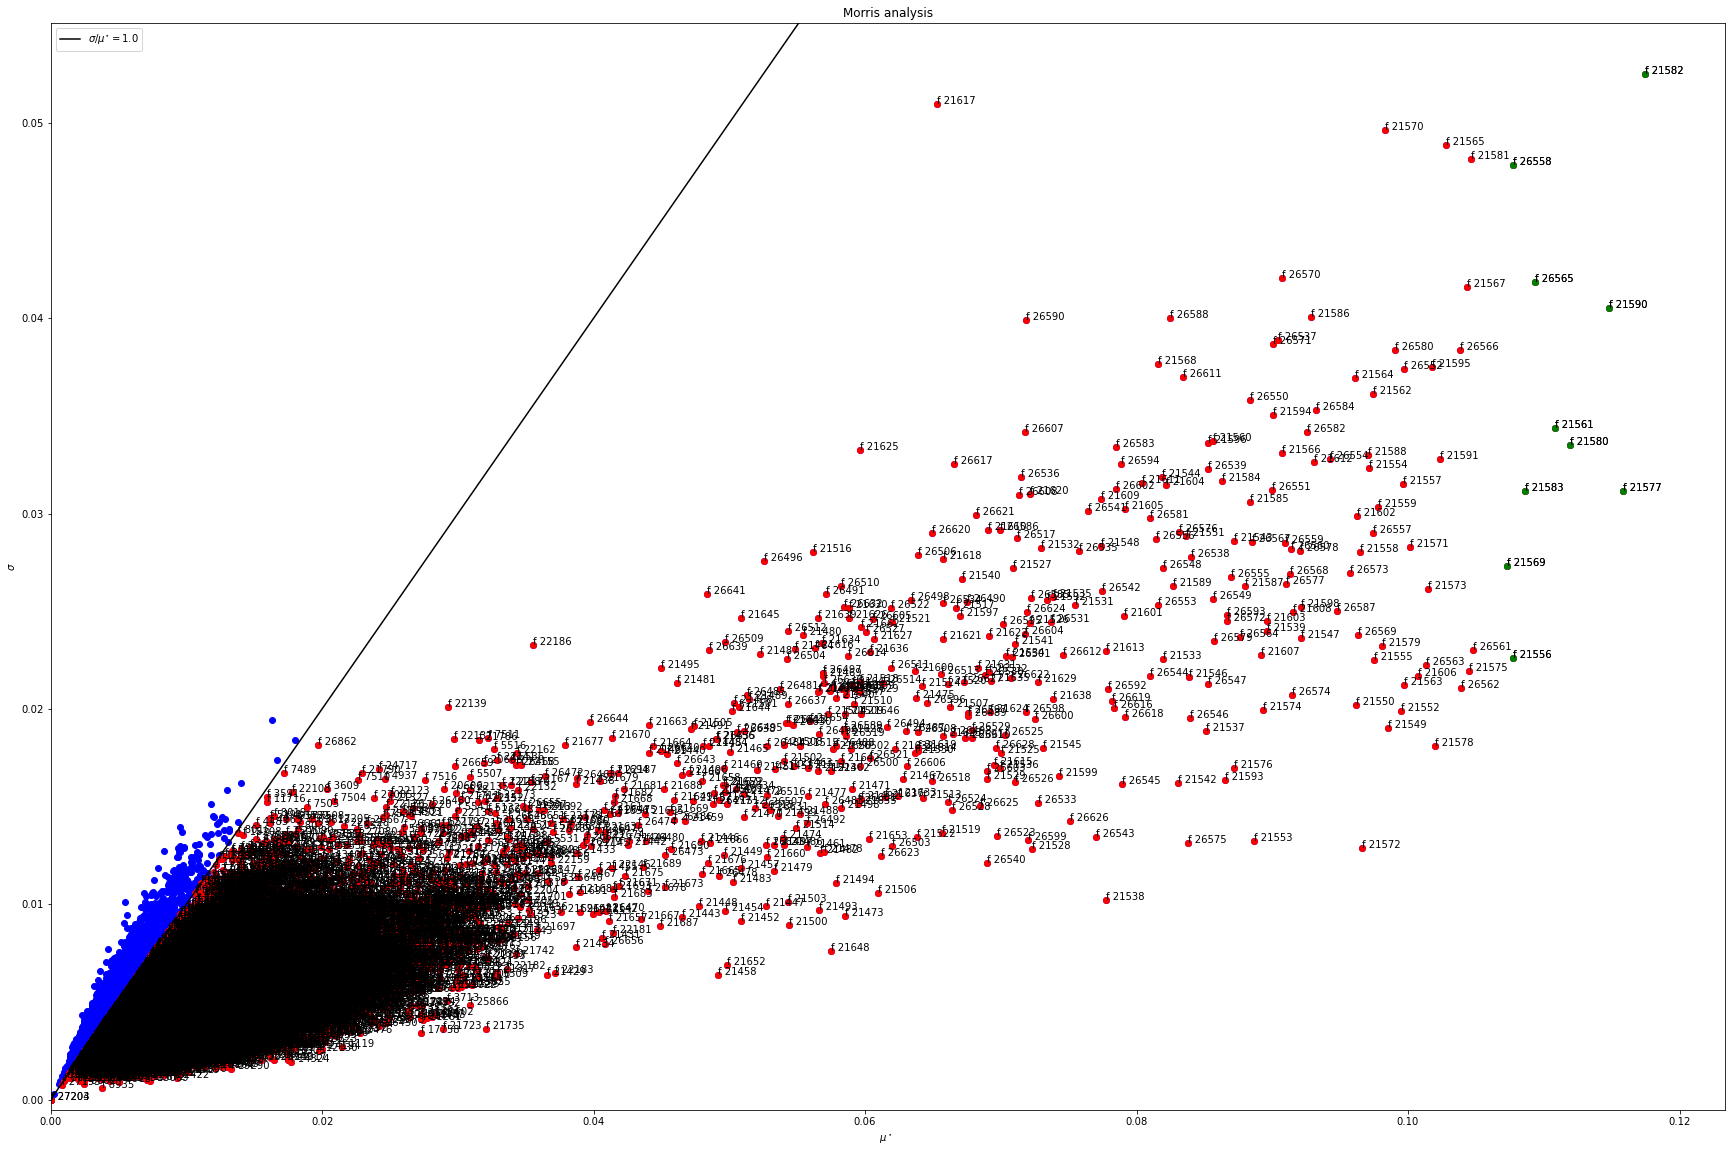

In [20]:
y = sigma
x = mu_star

fig, ax = plt.subplots(1, 1, figsize=(30, 20))

ax.scatter(x, y, c=u'b', marker=u'o')

ax.set_ylabel(r'$\sigma$')
ax.set_xlim(0,)
ax.set_ylim(0,)

x_axis_bounds = np.array(ax.get_xlim())

line1 = ax.plot(x_axis_bounds, x_axis_bounds, 'k-', label = r'$\sigma / \mu^{\star} = 1.0$')


for i in indlist:
    ax.annotate(si_morris['names'][i], (x[i], y[i]))
    ax.scatter(x[i], y[i], c=u'r', marker=u'o')

#     print('mu_star: {}, sigma: {}'.format(x[i],y[i]))

ys = sigma_sorted[-10:]
xs = mu_star_sorted[-10:]
names = names_sorted[-10:]
for i, txt in enumerate(names):
    ax.annotate(txt, (xs[i], ys[i]))
    ax.scatter(xs[i], ys[i], c=u'g', marker=u'o')

unit=''
ax.set_xlabel(r'$\mu^\star$ ' + unit)
ax.set_ylim(0-(0.01 * np.array(ax.get_ylim()[1])), )

ax.set_title('Morris analysis')
ax.legend( loc='upper left')

plt.show()

In [21]:
results_dir =  '../../../../data/zahs/Projects/results'


In [22]:
file_name = os.path.join(results_dir,'SA_morris_dacco')
fig.savefig(file_name,
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200,
            format='png')

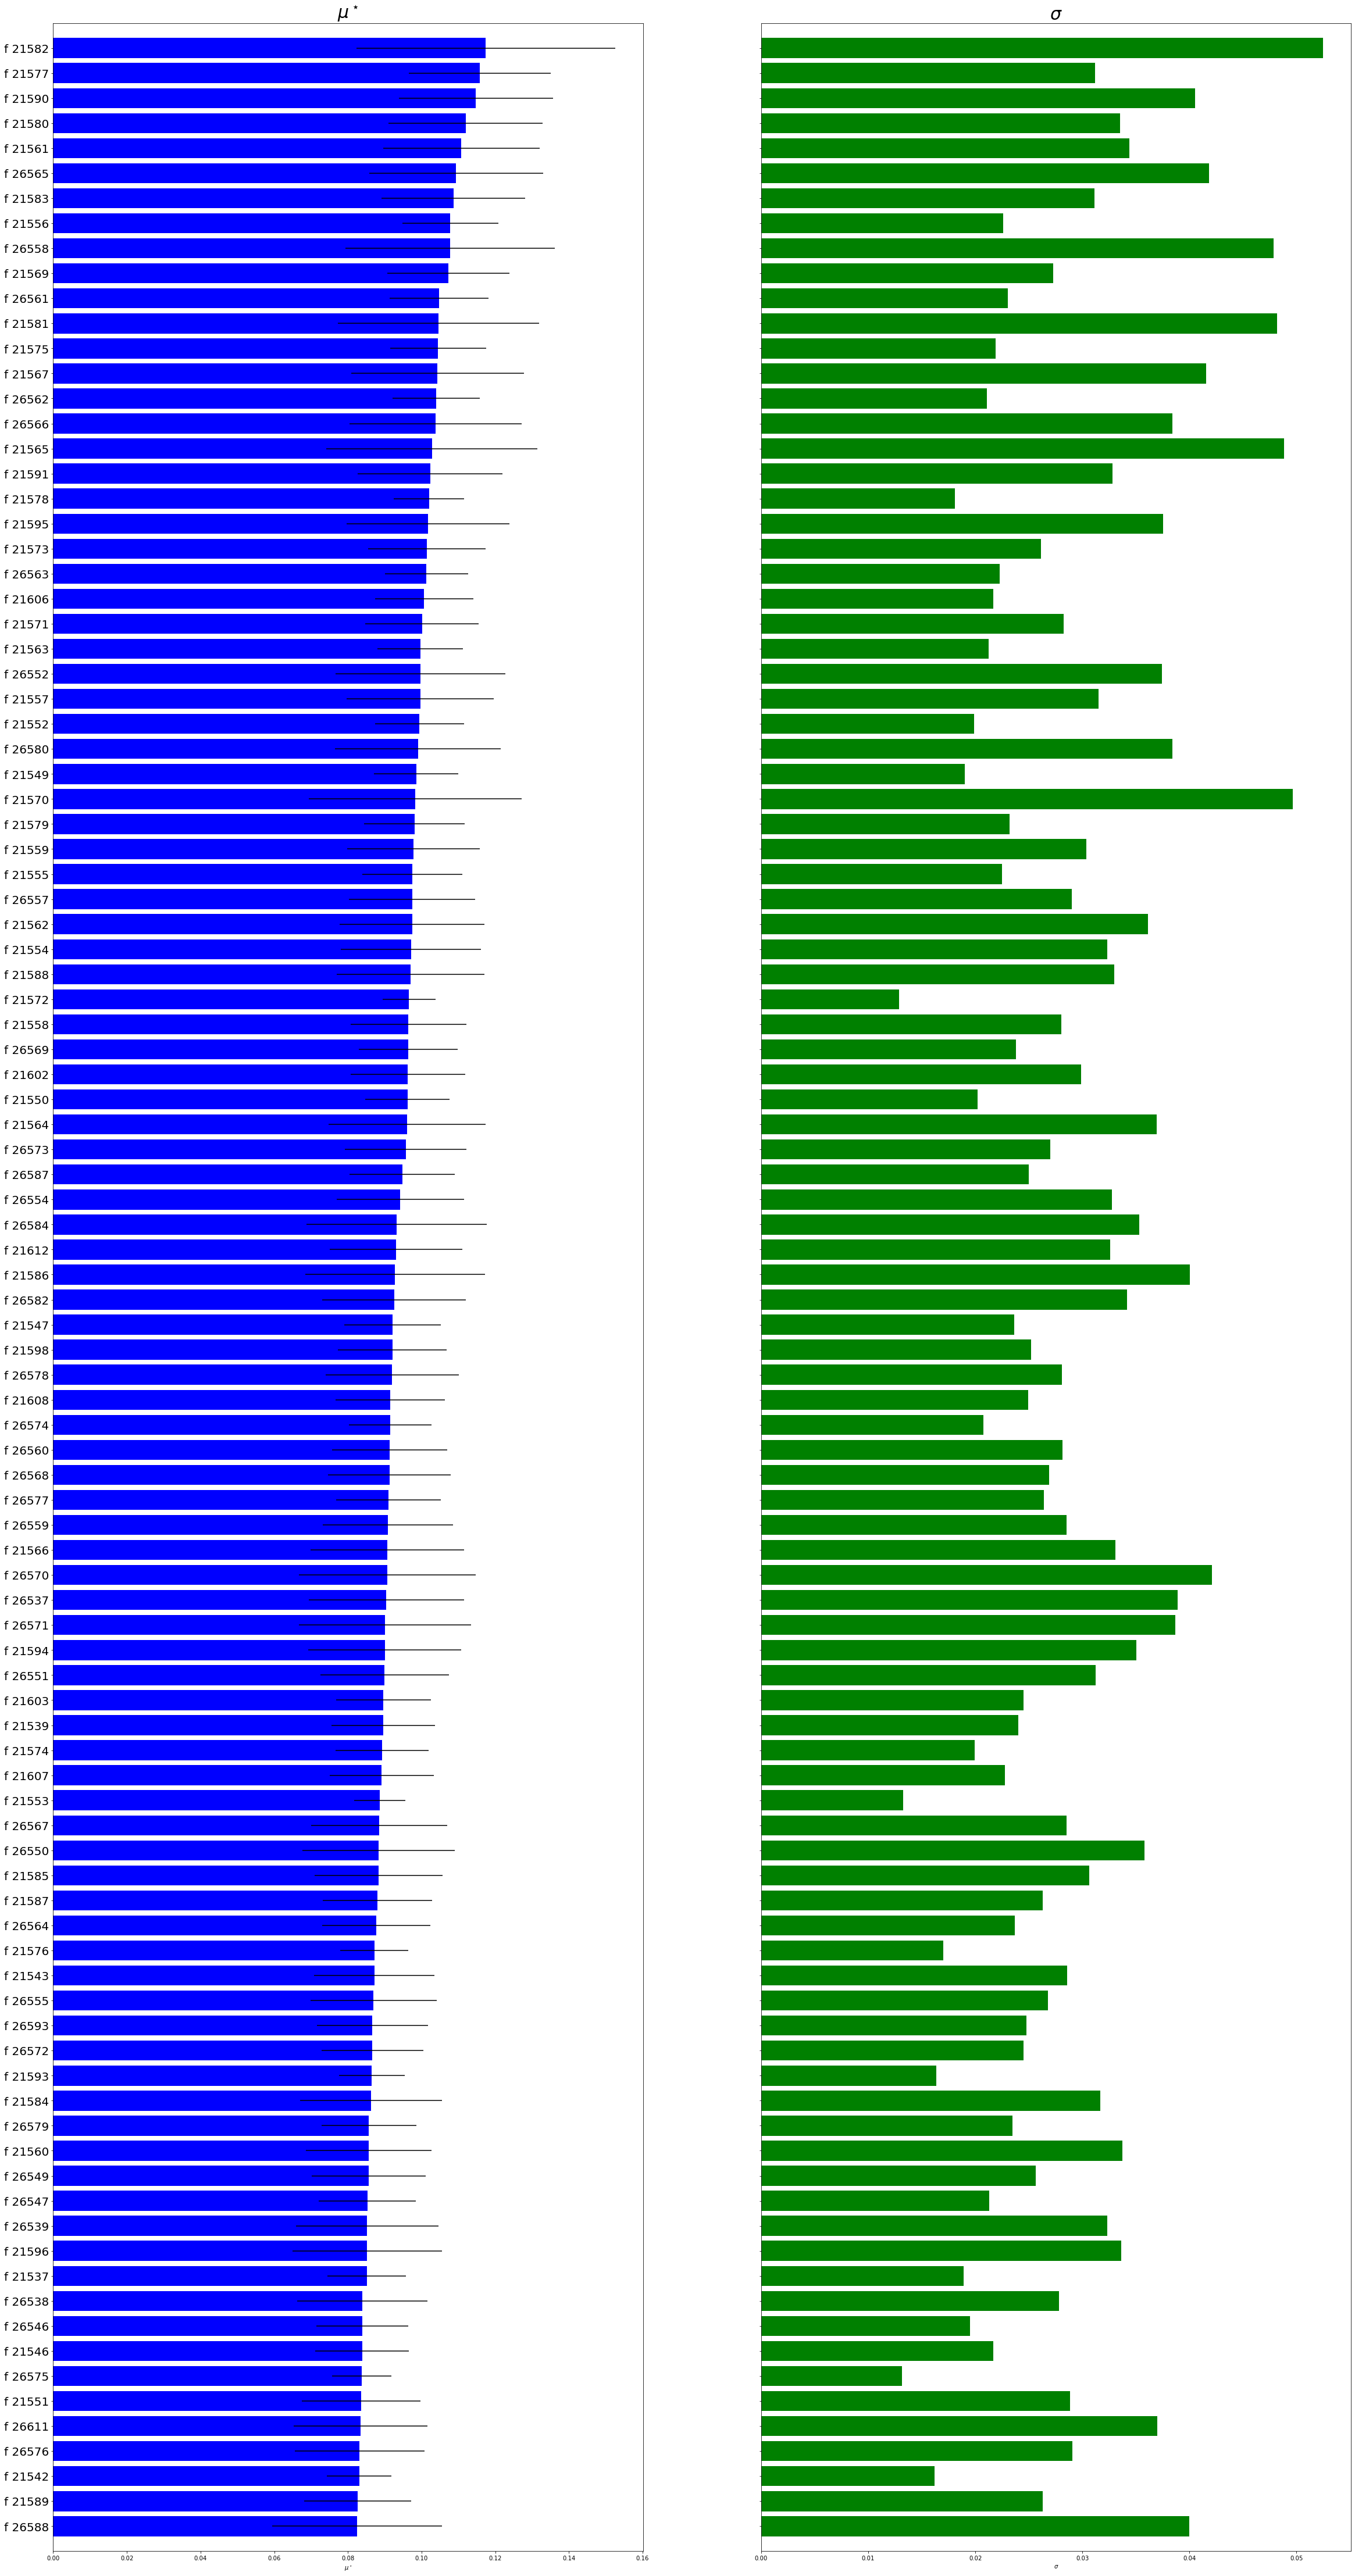

In [29]:
# Plot horizontal barchart
# y_pos = np.arange(len(names_sorted))
y_pos = np.arange(100)

plot_names = names_sorted[-100:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 80), sharey=True)

ax1.barh(y_pos,
         mu_star_sorted[-100:],
         xerr=mu_star_conf_sorted[-100:],
         align='center',
         ecolor='black',
         color='blue')


ax2.barh(y_pos,
         sigma_sorted[-100:],
         align='center',
         ecolor='black',
         color='green')

# plot mu_star distribution
ax1.set_yticks(y_pos)
ax1.set_yticklabels(plot_names,fontsize=20)
ax1.set_xlabel(r'$\mu^\star$')
ax1.set_ylim(min(y_pos)-1, max(y_pos)+1)
ax1.set_title('$\mu^\star$' , fontsize=30)

# plot sigma distribution
ax2.set_xlabel(r'$\sigma$')
ax2.set_ylim(min(y_pos)-1, max(y_pos)+1)
ax2.set_title('$\sigma$', fontsize=30)

plt.show()

In [24]:
file_name = os.path.join(results_dir,'SA_morris_dacco_bars_mu_sigm')
fig.savefig(file_name,
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200,
            format='png')